In [1]:
%load_ext autoreload

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import anndata
from torch.utils.data import DataLoader
import os

In [38]:
%autoreload 2
from self_supervision.data.datamodules import MultiomicsDataloader
from self_supervision.trainer.multiomics.multiomics_utils import one_hot_encode
from self_supervision.tester.multiomics.test import get_pred_dir, pearson_corr_per_cell, plot_results
from self_supervision.paths import RESULTS_FOLDER, MULTIMODAL_FOLDER, TRAINING_FOLDER

In [39]:
%autoreload 2
from self_supervision.tester.multiomics.test import evaluate_per_protein, evaluate_per_cell, evaluate_all

In [5]:
# Define font and tick properties
font = {'family': 'sans-serif', 'size': 5}  # Adjust the size as needed
fontdict = {'family': 'sans-serif', 'fontsize': 5}  # Adjust the size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # For tick labels

# Set the colorblind friendly palette
# Setting the style for the plots
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

# Get the list of colors in the palette
palette_colors = sns.color_palette("colorblind")

# Access the colors
color_supervised = palette_colors[0]  # First color
color_ssl = palette_colors[1]  # Second color
color_zeroshot = palette_colors[2]  # Third color
color_baseline = palette_colors[3]  # Forth color, ([3] looks similar to [0])
color_else1 = palette_colors[5]
color_else2 = palette_colors[6]
color_else3 = palette_colors[7]

# Evaluate Models

In [10]:
adata = sc.read_h5ad(os.path.join(MULTIMODAL_FOLDER, "NeurIPS_filtered_hvg_adata.h5ad"))
adata

AnnData object with n_obs × n_vars = 90261 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [11]:
test_ds = MultiomicsDataloader(np.log1p(adata[adata.obs['split'] == 'test'].obsm['protein_counts']),
                            adata[adata.obs['split'] == 'test'].X.todense(),
                            one_hot_encode(adata[adata.obs['split'] == 'test'].obs['batch']))

ood_test_ds = MultiomicsDataloader(np.log1p(adata[adata.obs['split'] == 'ood_test'].obsm['protein_counts']),
                                adata[adata.obs['split'] == 'ood_test'].X.todense(),
                                one_hot_encode(adata[adata.obs['split'] == 'ood_test'].obs['batch']))

In [12]:
test_dl = DataLoader(test_ds, shuffle=False, batch_size=512, num_workers=0)  
ood_test_dl = DataLoader(ood_test_ds, shuffle=False, batch_size=512, num_workers=0)  

In [13]:
len(test_dl.dataset.proteins)

8154

In [14]:
model_dirs = [
    # TRAINING_FOLDER + "/final_models/multiomics/New_No_SSL_run0/default/version_5/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/New_No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/New_No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/New_No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # TRAINING_FOLDER + "/final_models/multiomics/New_No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/No_SSL_new_run8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/No_SSL_new_run9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
        
    
    # SELF-SUPERVISED ON 20M DATA
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_20Mrun5/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_20Mrun6/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_20Mrun7/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_20Mrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_20Mrun9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    
    # SELF-SUPERVISED ON NEURIPS DATA
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun1/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun2/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun3/default/version_1/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun4/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun5/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun6/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun7/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
]

### Cross-Modality Prediction

In [15]:
all_protein_predictions, all_embs = get_pred_dir(model_dirs=model_dirs, adata=adata, test_dl=test_dl)

Getting predictions for New_No_SSL_run1...
Getting predictions for New_No_SSL_run2...
Getting predictions for New_No_SSL_run3...
Getting predictions for No_SSL_new_run8...
Getting predictions for No_SSL_new_run9...
Getting predictions for SSL_Random_Mask_20Mrun5...
Getting predictions for SSL_Random_Mask_20Mrun6...
Getting predictions for SSL_Random_Mask_20Mrun7...
Getting predictions for SSL_Random_Mask_20Mrun8...
Getting predictions for SSL_Random_Mask_20Mrun9...
Getting predictions for SSL_Random_Mask_NeurIPSrun0...
Getting predictions for SSL_Random_Mask_NeurIPSrun1...
Getting predictions for SSL_Random_Mask_NeurIPSrun2...
Getting predictions for SSL_Random_Mask_NeurIPSrun4...
Getting predictions for SSL_Random_Mask_NeurIPSrun9...


In [16]:
observed = test_ds.proteins  # assuming test_ds.proteins is a DataFrame
predictions = all_protein_predictions  # dictionary with model names as keys and predictions as values
dataset_size = predictions['New_No_SSL_run1'].shape[0]
gene_dim = 2000
n_proteins = 134

In [17]:
# List of results to manually append
base_path = os.path.join(TRAINING_FOLDER, 'final_models', 'multiomics')

baseline = ['linear.pt', 'new_totalVI_run0.pt', 'new_totalVI_run1.pt', 'new_totalVI_run2.pt', 'new_totalVI_run3.pt', 'new_totalVI_run4.pt']
all_predictions = predictions
for method in baseline:
    model_name = method.split('.')[0]
    print('Append Model', model_name)
    
    # Create a tensor of zeros with the required shape
    zero_filled_tensor = torch.zeros_like(predictions['New_No_SSL_run1'])
    
    # Fill tensor with predictions of method
    new_predictions = torch.load(base_path + method)
    zero_filled_tensor[:, gene_dim : gene_dim + n_proteins] = new_predictions

    # Append prediction to predictions
    all_predictions[model_name] = zero_filled_tensor

Append Model linear
Append Model new_totalVI_run0
Append Model new_totalVI_run1
Append Model new_totalVI_run2
Append Model new_totalVI_run3
Append Model new_totalVI_run4


In [18]:
# 1) Average per cell -> all cells
results_cell_all, mean_results_cell_all = evaluate_per_cell(observed, all_predictions, metrics=["pearson", "spearman", "mse"], difficult=False)

# 2) Average per protein -> all proteins
results_protein_all, mean_results_protein_all = evaluate_per_protein(observed, all_predictions, metrics=["pearson", "spearman", "mse"], difficult=False)

# 3) Average per cell -> "difficult" cells
results_cell_diff, mean_results_cell_diff = evaluate_per_cell(observed, all_predictions, metrics=["pearson", "spearman", "mse"], difficult=True, threshold=0.9)

# 4) Average per protein -> "difficult" proteins
results_protein_diff, mean_results_protein_diff = evaluate_per_protein(observed, all_predictions, metrics=["pearson", "spearman", "mse"], difficult=True, threshold=0.9)

Kept  85512 / 171234  cells
Kept  2415 / 2814  proteins


In [19]:
mean_results_cell_diff

,Model,Pearson Correlation,Spearman Correlation,MSE
0,New_No_SSL_run1,0.819238,0.804002,0.387695
1,New_No_SSL_run2,0.819532,0.805053,0.390658
2,New_No_SSL_run3,0.820277,0.805090,0.393396
3,No_SSL_new_run8,0.824035,0.807192,0.387314
4,No_SSL_new_run9,0.821261,0.805330,0.391909
5,SSL_Random_Mask_20Mrun5,0.826698,0.808780,0.358160
6,SSL_Random_Mask_20Mrun6,0.825524,0.807934,0.362954
7,SSL_Random_Mask_20Mrun7,0.827581,0.809631,0.359238
8,SSL_Random_Mask_20Mrun8,0.827684,0.809759,0.356781
9,SSL_Random_Mask_20Mrun9,0.826857,0.809254,0.358585


In [21]:
# 5) No average
mean_results_all = evaluate_all(observed, predictions, metrics=["pearson", "spearman", "mse"])

In [27]:
# From totalVI notebook

# Correct values for totalVI runs
corrections = [
    (0.890295272847298, 0.8115996152725243, 14588.20703125),
    (0.8916069415460626, 0.8295023697216307, 14744.67578125),
    (0.8911558233855509, 0.8113400014053658, 15297.126953125),
    (0.890295272847298, 0.8115996152725243, 14588.20703125),
    (0.8916765010517294, 0.823405473557941, 14879.3232421875)
]

# Update the DataFrame
totalVI_indices = mean_results_cell_all.index[mean_results_cell_all['Model'].str.contains('totalVI')]

for idx, (pearson, spearman, mse) in zip(totalVI_indices, corrections):
    mean_results_cell_all.at[idx, 'Pearson Correlation'] = pearson
    mean_results_cell_all.at[idx, 'Spearman Correlation'] = spearman
    mean_results_cell_all.at[idx, 'MSE'] = mse

# Display the updated DataFrame
mean_results_cell_all

,Model,Pearson Correlation,Spearman Correlation,MSE
0,New_No_SSL_run1,0.859662,0.847597,0.424459
1,New_No_SSL_run2,0.860644,0.848869,0.434684
2,New_No_SSL_run3,0.862003,0.849791,0.436064
3,No_SSL_new_run8,0.866688,0.852530,0.425999
4,No_SSL_new_run9,0.864961,0.851312,0.422648
5,SSL_Random_Mask_20Mrun5,0.871533,0.856215,0.376298
6,SSL_Random_Mask_20Mrun6,0.868857,0.853877,0.388953
7,SSL_Random_Mask_20Mrun7,0.872039,0.856536,0.385076
8,SSL_Random_Mask_20Mrun8,0.872318,0.856974,0.383617
9,SSL_Random_Mask_20Mrun9,0.871679,0.856574,0.391081


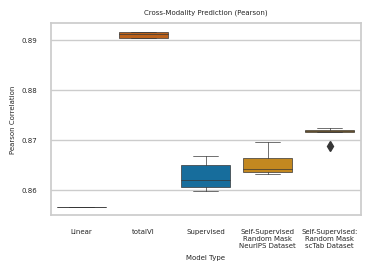

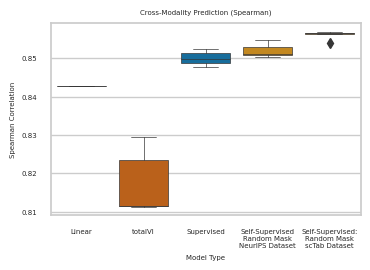

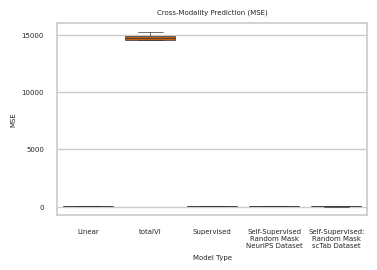

In [45]:
# 1) Average per cell -> all cells
plot_results(mean_results_cell_all, color_supervised=color_supervised, color_ssl=color_ssl, color_baseline=color_baseline, save_flag=True, include_linear=True, save_path=os.path.join(RESULTS_FOLDER, "multiomics"), setting='1_avg_all_cells')

In [32]:
# Correct values for totalVI runs
corrections = [
    (0.8064288790933437, 0.8186388266504266, 14588.208984375),
    (0.8108340161749529, 0.8223101460854639, 14744.6767578125),
    (0.8063893349287719, 0.8177863058468345, 15297.12890625),
    (0.8064288790933437, 0.8186388266504266, 14588.208984375),
    (0.8116708658721783, 0.8227430892407459, 14879.322265625)
]

# Update the DataFrame
totalVI_indices = mean_results_protein_all.index[mean_results_protein_all['Model'].str.contains('totalVI')]

for idx, (pearson, spearman, mse) in zip(totalVI_indices, corrections):
    mean_results_protein_all.at[idx, 'Pearson Correlation'] = pearson
    mean_results_protein_all.at[idx, 'Spearman Correlation'] = spearman
    mean_results_protein_all.at[idx, 'MSE'] = mse


In [33]:
mean_results_protein_all

,Model,Pearson Correlation,Spearman Correlation,MSE
0,New_No_SSL_run1,0.792188,0.747769,0.424460
1,New_No_SSL_run2,0.792461,0.746624,0.434684
2,New_No_SSL_run3,0.789425,0.745017,0.436064
3,No_SSL_new_run8,0.792504,0.747233,0.425999
4,No_SSL_new_run9,0.794082,0.748200,0.422648
5,SSL_Random_Mask_20Mrun5,0.809934,0.765766,0.376298
6,SSL_Random_Mask_20Mrun6,0.805477,0.762132,0.388953
7,SSL_Random_Mask_20Mrun7,0.807209,0.763988,0.385076
8,SSL_Random_Mask_20Mrun8,0.807468,0.763351,0.383617
9,SSL_Random_Mask_20Mrun9,0.806943,0.763671,0.391081


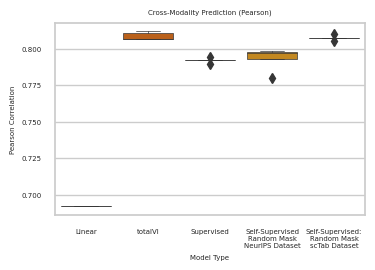

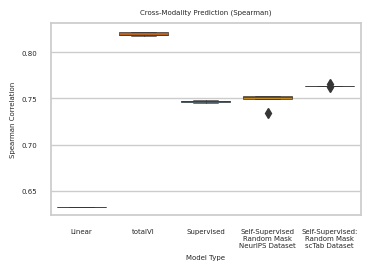

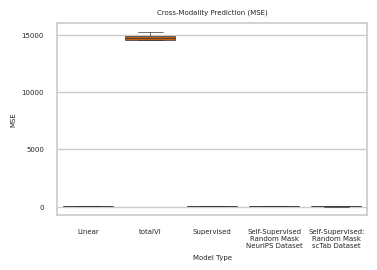

In [46]:
# 2) Average per protein -> all proteins
plot_results(mean_results_protein_all, color_supervised=color_supervised, color_ssl=color_ssl, color_baseline=color_baseline, save_flag=True, include_linear=True, save_path=os.path.join(RESULTS_FOLDER, "multiomics"), setting='2_all_proteins')

In [30]:
# From totalVI notebook

# Correct values for totalVI runs
corrections = [
    (0.8244797109032888, 0.7859776302858185, 3702.87060546875),
    (0.8246858564105867, 0.8036471597618083, 3736.008544921875),
    (0.8259447221736733, 0.7857914053931299, 3720.218994140625),
    (0.8244797109032888, 0.7859776302858185, 3702.87060546875),
    (0.8242086365098727, 0.7938982186436275, 3704.829833984375)
]

# Update the DataFrame
totalVI_indices = mean_results_cell_diff.index[mean_results_cell_diff['Model'].str.contains('totalVI')]

for idx, (pearson, spearman, mse) in zip(totalVI_indices, corrections):
    mean_results_cell_diff.at[idx, 'Pearson Correlation'] = pearson
    mean_results_cell_diff.at[idx, 'Spearman Correlation'] = spearman
    mean_results_cell_diff.at[idx, 'MSE'] = mse

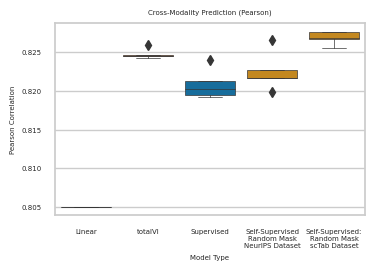

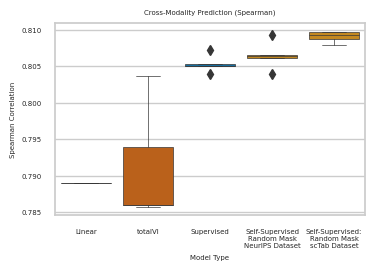

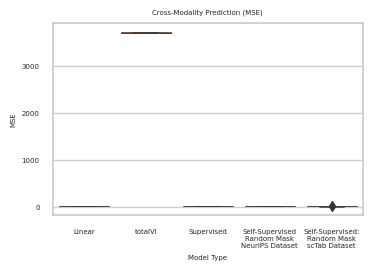

In [47]:
# 3) Average per cell -> "difficult" cells
plot_results(mean_results_cell_diff, color_supervised=color_supervised, color_ssl=color_ssl, color_baseline=color_baseline, save_flag=True, include_linear=True, save_path=os.path.join(RESULTS_FOLDER, "multiomics"), setting='3_avg_diff_cells')

In [36]:
# Correct values for totalVI runs
corrections = [
    (0.7557488273437004, 0.7937780386112997, 2686.7451171875),
    (0.769668900516337, 0.8013798184866855, 19727.091796875),
    (0.7544390455799566, 0.7909074957263609, 2690.250244140625),
    (0.7557488273437004, 0.7937780386112997, 2686.7451171875),
    (0.7693661507606185, 0.8019803761895475, 2597.7158203125)
]

# Update the DataFrame
totalVI_indices = mean_results_protein_diff.index[mean_results_protein_diff['Model'].str.contains('totalVI')]

for idx, (pearson, spearman, mse) in zip(totalVI_indices, corrections):
    mean_results_protein_diff.at[idx, 'Pearson Correlation'] = pearson
    mean_results_protein_diff.at[idx, 'Spearman Correlation'] = spearman
    mean_results_protein_diff.at[idx, 'MSE'] = mse


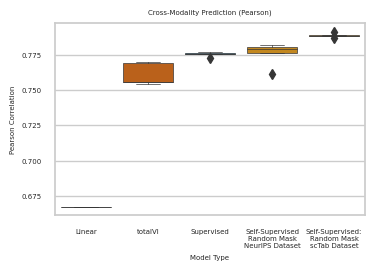

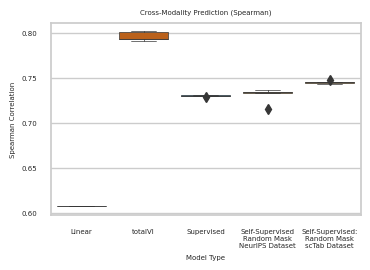

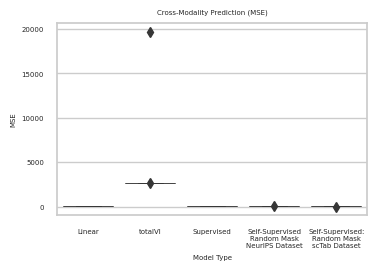

In [49]:
# 4) Average per protein -> "difficult" proteins
plot_results(mean_results_protein_diff, color_supervised=color_supervised, color_ssl=color_ssl, color_baseline=color_baseline, save_flag=True, include_linear=True, save_path=os.path.join(RESULTS_FOLDER, "multiomics"), setting='4_avg_diff_proteins')

In [23]:
# Correct values for totalVI runs
corrections = [
    (0.8549065010818786, 0.8589674272696783, 14588.212890625),
    (0.8448489802411264, 0.8748080205719706, 14744.673828125),
    (0.8570708322275049, 0.8585074196856345, 15297.126953125),
    (0.8549065010818786, 0.8589674272696783, 14588.212890625),
    (0.8551916422514113, 0.871492474302385, 14879.3232421875)
]

# Update the DataFrame
totalVI_indices = mean_results_all.index[mean_results_all['Model'].str.contains('totalVI')]

for idx, (pearson, spearman, mse) in zip(totalVI_indices, corrections):
    mean_results_all.at[idx, 'Pearson Correlation'] = pearson
    mean_results_all.at[idx, 'Spearman Correlation'] = spearman
    mean_results_all.at[idx, 'MSE'] = mse

# Display the updated DataFrame
mean_results_all

                          Model  Pearson Correlation  Spearman Correlation  \
0               New_No_SSL_run1             0.880465              0.860849   
1               New_No_SSL_run2             0.880338              0.859758   
2               New_No_SSL_run3             0.878808              0.859009   
3               No_SSL_new_run8             0.882469              0.861011   
4               No_SSL_new_run9             0.882227              0.860708   
5       SSL_Random_Mask_20Mrun5             0.895671              0.873151   
6       SSL_Random_Mask_20Mrun6             0.892404              0.870832   
7       SSL_Random_Mask_20Mrun7             0.894495              0.872596   
8       SSL_Random_Mask_20Mrun8             0.894754              0.872490   
9       SSL_Random_Mask_20Mrun9             0.893976              0.872447   
10  SSL_Random_Mask_NeurIPSrun0             0.875801              0.855799   
11  SSL_Random_Mask_NeurIPSrun1             0.884225            

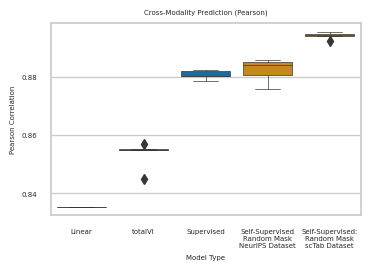

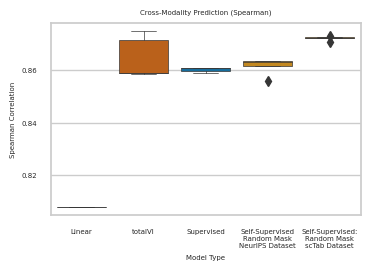

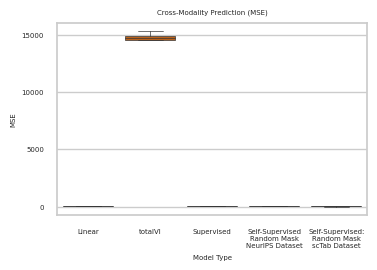

In [48]:
# 5) No Average
plot_results(mean_results_all, color_supervised=color_supervised, color_ssl=color_ssl, color_baseline=color_baseline, save_flag=True, include_linear=True, save_path=os.path.join(RESULTS_FOLDER, "multiomics"), setting='5_no_avg')

# Figure 2 - Plot Correlations

In [78]:
adata_test = adata[adata.obs['split'] == 'test']
adata_test

View of AnnData object with n_obs × n_vars = 8154 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [79]:
model_dirs = [
    TRAINING_FOLDER + "/final_models/multiomics/New_No_SSL_run0/default/version_5/checkpoints/best_checkpoint_val.ckpt",
    TRAINING_FOLDER + "/final_models/multiomics/SSL_Random_Mask_20Mrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
]

In [80]:
all_protein_predictions, all_embs = get_pred_dir(model_dirs=model_dirs, adata=adata_test, test_dl=test_dl)

Getting predictions for New_No_SSL_run0...
Getting predictions for SSL_Random_Mask_20Mrun8...


In [81]:
all_embs

{'New_No_SSL_run0': tensor([[ 0.4816,  0.3323, -0.1568,  ..., -0.1467, -0.2975, -0.0437],
         [ 0.4592,  0.3377, -0.1007,  ..., -0.1875, -0.3005, -0.0796],
         [-0.1522,  0.1465,  0.0746,  ...,  0.0304,  0.1418,  0.0810],
         ...,
         [-0.2316,  0.4064, -0.0258,  ...,  0.3267,  0.1807,  0.1486],
         [ 0.0044,  0.0083, -0.1853,  ...,  0.3836,  0.4285, -0.1254],
         [ 0.0289,  0.0357, -0.0902,  ...,  0.3174,  0.4263, -0.0198]]),
 'SSL_Random_Mask_20Mrun8': tensor([[ 0.0272,  0.0400, -0.0127,  ...,  0.0521, -0.0340, -0.0099],
         [ 0.0298,  0.0334, -0.0091,  ...,  0.0595, -0.0335, -0.0039],
         [ 0.0416,  0.0066, -0.0008,  ...,  0.0171, -0.0151, -0.0145],
         ...,
         [ 0.0028,  0.0596, -0.0072,  ...,  0.0581, -0.0265, -0.0129],
         [ 0.0084,  0.0613,  0.0041,  ...,  0.0457, -0.0190, -0.0143],
         [ 0.0004,  0.0588, -0.0134,  ...,  0.0564, -0.0252, -0.0069]])}

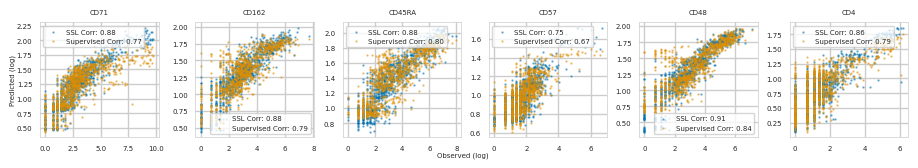

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch

# Set the font dictionary for the plots
font = {'family': 'sans-serif', 'size': 5}
plt.rc('font', **font)

# Assuming 'adata_test' is your AnnData object and 'all_protein_predictions' is your prediction dictionary
# Convert true protein counts from AnnData to DataFrame and take log
protein_names = list(adata_test.obsm['protein_counts'].columns)
true_proteins_df = pd.DataFrame(adata_test.obsm['protein_counts'], columns=protein_names)
true_proteins_log = np.log1p(true_proteins_df)

# Convert predictions to DataFrames and take log, ensuring indices match
predictions_dfs = {}
correlations = []
for model_name, pred_tensor in all_protein_predictions.items():
    pred_df = pd.DataFrame(pred_tensor.numpy()[:, 2000:2134], index=true_proteins_df.index, columns=protein_names)
    predictions_dfs[model_name] = np.log1p(pred_df)  # Assuming predictions need to be log-transformed

for model_name, pred_df in predictions_dfs.items():
    for protein in protein_names:
        corr = pearsonr(true_proteins_log[protein], pred_df[protein])[0]
        correlations.append((protein, model_name, corr))

# Create a DataFrame from the correlations
correlations_df = pd.DataFrame(correlations, columns=['Protein', 'Model', 'Correlation'])

# Pivot the DataFrame to have models as columns
correlations_pivot = correlations_df.pivot(index='Protein', columns='Model', values='Correlation')

# Calculate the absolute difference in correlations between the two models
correlations_pivot['Corr_Diff'] = abs(correlations_pivot['SSL_Random_Mask_20Mrun8'] - correlations_pivot['New_No_SSL_run0'])

# Sort by the difference and select the top 16 proteins
selected_proteins = correlations_pivot.nlargest(6, 'Corr_Diff').index.tolist()

# Initialize the plot with a smaller figure size
fig, axes = plt.subplots(1, 6, figsize=(9, 1.5), constrained_layout=True)
axes = axes.flatten()

for i, protein in enumerate(selected_proteins):
    ax = axes[i]
    
    # Calculate correlations for the legend
    corr_ssl = correlations_pivot.at[protein, 'SSL_Random_Mask_20Mrun8']
    corr_supervised = correlations_pivot.at[protein, 'New_No_SSL_run0']
    
    # Randomly sample 100 points for plotting
    sample_indices = np.random.choice(true_proteins_log.index, size=1000, replace=False)
    sampled_true_proteins = true_proteins_log.loc[sample_indices, protein]
    sampled_predictions_ssl = predictions_dfs['SSL_Random_Mask_20Mrun8'].loc[sample_indices, protein]
    sampled_predictions_supervised = predictions_dfs['New_No_SSL_run0'].loc[sample_indices, protein]
    
    # Scatter plot for SSL model
    ax.scatter(sampled_true_proteins, sampled_predictions_ssl,
               alpha=0.5, s=0.5, label=f'SSL Corr: {corr_ssl:.2f}')  # Add appropriate color if needed
    
    # Scatter plot for Supervised model
    ax.scatter(sampled_true_proteins, sampled_predictions_supervised,
               alpha=0.5, s=0.5, label=f'Supervised Corr: {corr_supervised:.2f}')  # Add appropriate color if needed
    
    # Create the legend with the specified font size
    ax.legend(prop={'size': font['size']})

    # Set the linewidth of the plot box and adjust tick length
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    ax.tick_params(axis='both', which='major', labelsize=font['size'], width=0.5, length=2)

    # Set the title with the specified font size
    ax.set_title(f'{protein}', fontsize=font['size'])

# Set common labels with adjusted coordinates and padding
fig.text(0.5, 0.001, 'Observed (log)', ha='center', va='center', fontsize=font['size'])
fig.text(0.001, 0.5, 'Predicted (log)', ha='center', va='center', rotation='vertical', fontsize=font['size'])

# Assuming RESULTS_FOLDER is defined
plt.savefig(RESULTS_FOLDER + "/multiomics/Corr_Plots.svg", bbox_inches='tight')  # Save as SVG
plt.show()
